# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

In [2]:
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# 1.Fine-tune a Chemical Language Model on Lipophilicity

## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [3]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [4]:
# Explore the dataset
# dataset structure
print(dataset)
# column names with first few rows
df = pd.DataFrame(dataset['train'][0:3])
print(df.to_string(index=False))

DatasetDict({
    train: Dataset({
        features: ['SMILES', 'label'],
        num_rows: 4200
    })
})
                                                   SMILES  label
                  Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   3.54
COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23  -1.18
                   COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   3.69


In [5]:
# define a PyTorch Dataset class for handling SMILES strings and targets
class SMILESDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
        """
        dataset: hugging Face dataset containing SMILES and label
        tokenizer: tokenizer for converting SMILES into tokenized form
        max_length: maximum token length for truncation and padding
        """
        self.smiles = dataset['SMILES']
        self.labels = dataset['label']
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        returns total number of samples in the dataset
        """
        return len(self.smiles)

    def __getitem__(self, i):
        """
        retrieves tokenized SMILES and label of a sample with index i
        """
        encoding = self.tokenizer(
            self.smiles[i],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        # convert label to tensor
        label = torch.tensor(self.labels[i], dtype=torch.float)

        # dictionary of tokenized input (input_ids:tensor and attention_mask:tensor key:value pairs)
        # and the corresponding label tensor
        return {key: val.squeeze(0) for key, val in encoding.items()}, label

## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [6]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
# split the data into training and test datasets

# extract SMILES and labels
smiles_list = dataset['train']['SMILES']
labels_list = dataset['train']['label']

# split into train and test sets (80:20)
train_smiles, test_smiles, train_labels, test_labels = train_test_split(
    smiles_list, labels_list, test_size=0.2, random_state=42
)

# create SMILESDataset objects
train_dataset = SMILESDataset({'SMILES': train_smiles, 'label': train_labels}, tokenizer)
test_dataset = SMILESDataset({'SMILES': test_smiles, 'label': test_labels}, tokenizer)

# inspect train and test dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 3360
Testing dataset size: 840


In [8]:
# let's look at an example entry of the train set
sample_input, sample_label = train_dataset[0]

print("Raw SMILES:", train_smiles[0]) 
print("Tokenized Input IDs:", sample_input["input_ids"]) 
print("Attention Mask:", sample_input["attention_mask"])
print("Corresponding Label:", sample_label)

Raw SMILES: COc1ccc(CC(=O)NC(N\C(=N\C#N)\Nc2ccccc2C)C(C)(C)C)cc1OC
Tokenized Input IDs: tensor([ 0,  4,  9,  5,  8,  5,  5,  5,  6,  4,  4,  6, 12,  9,  7, 10,  4,  6,
        10, 33,  4,  6, 12, 10, 33,  4, 25, 10,  7, 33, 10,  5, 11,  5,  5,  5,
         5,  5, 11,  4,  7,  4,  6,  4,  7,  6,  4,  7,  4,  7,  5,  5,  8,  9,
         4,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

# check number of batches in train and test sets
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 210
Number of test batches: 53


## --- Step 3: Load Model ---

In [10]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

In [11]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, pretrained_model):
        """
        pretrained_model: MoLFormer model to be loaded and and modified by adding a regression head
        """        
        super(MoLFormerWithRegressionHead, self).__init__()
        self.molformer = pretrained_model
        # regression head: fully connected linear layer that maps the hidden state output to a single regression value (lipophilicity)
        self.regression_head = nn.Linear(self.molformer.config.hidden_size, 1) 
        
    def forward(self, input_ids, attention_mask):
        """
        performs a forward pass through the model

        input_ids: tokenized SMILES sequences (batch_size, seq_length).
        attention_mask: attention mask for padding (batch_size, seq_length).

        returns the predicted values (batch_size, 1)
        """
        # get outputs from pre-trained model
        outputs = self.molformer(input_ids=input_ids, attention_mask=attention_mask)
        # last hidden state is of shape (batch_size, sequence_length, hidden_size)
        # for each sample in batch select first token ([CLS] token) which captures a summary representation of the sequence
        # use it as a representative embedding for input for the regression head
        pooled_output = outputs.last_hidden_state[:, 0] 
        # pass through linear layer
        logits = self.regression_head(pooled_output)
        return logits

In [12]:
# initialize the regression model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

## --- Step 4: Training ---

In [13]:
# we use mean squared error as a loss function and AdamW as optimization method
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=5e-5) 

# chosen after observing training and evaluation loss graph
EPOCHS = 8

train_losses = []

for epoch in range(EPOCHS):
    regression_model.train()
    print(f"\nStarting Epoch {epoch + 1}/{EPOCHS}...\n")
    total_train_loss = 0
        
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch + 1}")
 
    for batch_id, batch in progress_bar:
        # reset gradients
        optimizer.zero_grad()  
        
        # extract dictionary containing input_ids and attention_mask and extract labels
        batch_inputs = batch[0]  
        labels = batch[1].to(device)

        input_ids = batch_inputs['input_ids'].to(device)
        attention_mask = batch_inputs['attention_mask'].to(device)
        
        # forward pass
        predictions = regression_model(input_ids, attention_mask)
        
        # compute loss
        loss = criterion(predictions, labels.view(-1, 1))
        total_train_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()

        if batch_id % 10 == 0:
            avg_loss = total_train_loss  / (batch_id + 1)
            progress_bar.set_postfix({"Batch Loss": loss.item(), "Avg Loss": avg_loss})

    # epoch results
    avg_train_loss = total_train_loss  / len(train_dataloader)
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} completed. Training Loss: {avg_train_loss:.4f}\n")


Starting Epoch 1/8...



Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1/8 completed. Training Loss: 1.0035


Starting Epoch 2/8...



Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/8 completed. Training Loss: 0.4946


Starting Epoch 3/8...



Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3/8 completed. Training Loss: 0.3543


Starting Epoch 4/8...



Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/8 completed. Training Loss: 0.2852


Starting Epoch 5/8...



Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5/8 completed. Training Loss: 0.2256


Starting Epoch 6/8...



Epoch 6:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/8 completed. Training Loss: 0.2019


Starting Epoch 7/8...



Epoch 7:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7/8 completed. Training Loss: 0.1718


Starting Epoch 8/8...



Epoch 8:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/8 completed. Training Loss: 0.1525



## --- Step 5: Evaluation ---

In [14]:
# set model to evaluation mode
regression_model.eval()  
all_preds = []
all_labels = []
total_test_loss = 0
with torch.no_grad():  # no gradient calculation
    for batch in test_dataloader:
        inputs, labels = batch

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        outputs = regression_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.squeeze().cpu().numpy()
        labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# compute evaluation metrics
metrics = {
    'MSE': mean_squared_error(all_labels, all_preds), 
    'MAE': mean_absolute_error(all_labels, all_preds),
    'R2': r2_score(all_labels, all_preds),
}

print(f"Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {metrics['MSE']:.4f}")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.4f}")
print(f"R² Score: {metrics['R2']:.4f}")

Test Set Evaluation:
Mean Squared Error (MSE): 0.4723
Mean Absolute Error (MAE): 0.5316
R² Score: 0.6804


In [15]:
torch.save(regression_model.state_dict(), "molformer_regression_finetuned.pth")

# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.

In [16]:
def mask_tokens(inputs, tokenizer, mlm_probability=0.15):
    """
    applies an MLM mask: randomly select 15% (default) of the tokens for replacement and:
        - replace 80% of them with [MASK] token
        - replace 10% with a random token
        - leave 10% unchanged (but still include them in loss calculation)
    """
    # create copy of input tokens to be used as labels when predicting masked tokens
    labels = inputs.clone()

    # ensure inputs are in format (batch_size, seq_length) ################
    if labels.dim() == 1:  
        labels = labels.unsqueeze(0)

    # get dimensions to create the token mask
    batch_size, seq_length = labels.shape

    # get special token ([CLS], [SEP]...) mask
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(seq, already_has_special_tokens=True) 
        for seq in labels.tolist()
    ]
    special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool, device=inputs.device)

    # create mask probability matrix
    probability_matrix = torch.full(labels.shape, mlm_probability, device=inputs.device)
    # avoid masking special tokens by setting probability to 0
    probability_matrix.masked_fill_(special_tokens_mask, value=0.0)  

    # apply masking
    masked_indices = torch.bernoulli(probability_matrix).bool()
    # ignore unmasked tokens when computing loss
    labels[~masked_indices] = -100

    # replace 80% of masked tokens with [MASK]
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8, device=inputs.device)).bool() & masked_indices
    inputs = inputs.reshape(batch_size, seq_length) 
    inputs[indices_replaced] = tokenizer.mask_token_id

    # replace 10% of masked tokens with a random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5, device=inputs.device)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long, device=inputs.device)
    inputs[indices_random] = random_words[indices_random]

    return inputs, labels

In [17]:
class MLMDataset(Dataset):
    """
    MLMDataset prepares dataset for unsupervised training
    """
    def __init__(self, smiles_list, tokenizer, max_length=128):
        """
        only takes smiles and not labels
        """
        self.tokenizer = tokenizer
        self.smiles_list = smiles_list
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, i):
        """
        tokenizes the smiles sequence as normal, then applies masking using mask_tokens()
        """
        smiles = self.smiles_list[i]
        
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0) 
        attention_mask = encoding["attention_mask"].squeeze(0)
        
        masked_input_ids, labels = mask_tokens(input_ids.clone(), self.tokenizer, mlm_probability = 0.25)

        return {
            "input_ids": masked_input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [18]:
# create mlm dataset from training data only
mlm_dataset = MLMDataset(smiles_list=train_smiles, tokenizer=tokenizer)
mlm_dataloader = DataLoader(mlm_dataset, batch_size=16, shuffle=True)

model.to(device)

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

In [19]:
# cross entropy loss (ignoring -100 labels of unmasked tokens) and AdamW optimization
criterion = torch.nn.CrossEntropyLoss(ignore_index=-100) 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


EPOCHS = 20
model.train()

for epoch in range(EPOCHS):
    print(f"\nStarting Epoch {epoch + 1}/{EPOCHS}...\n")    
    total_loss = 0

    progress_bar = tqdm(enumerate(mlm_dataloader), total=len(mlm_dataloader), desc=f"Epoch {epoch + 1}")    

    for batch_id, batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        input_ids = input_ids.squeeze(1) 

        # forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs[0]

        # compute loss manually
        loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_id % 10 == 0:
            avg_loss = total_loss / (batch_id + 1)
            progress_bar.set_postfix({"Batch Loss": loss.item(), "Avg Loss": avg_loss})
    
    # epoch results
    avg_epoch_loss = total_loss / len(mlm_dataloader)
    print(f"Epoch {epoch + 1}/{EPOCHS} completed. Average Loss: {avg_epoch_loss:.4f}\n")

# save fine-tuned model for downstream training on lipophilicity task
model.save_pretrained("molformer_mlm_finetuned")


Starting Epoch 1/20...



Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1/20 completed. Average Loss: 2.1181


Starting Epoch 2/20...



Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/20 completed. Average Loss: 0.8911


Starting Epoch 3/20...



Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3/20 completed. Average Loss: 0.6747


Starting Epoch 4/20...



Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/20 completed. Average Loss: 0.5572


Starting Epoch 5/20...



Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5/20 completed. Average Loss: 0.4837


Starting Epoch 6/20...



Epoch 6:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/20 completed. Average Loss: 0.4509


Starting Epoch 7/20...



Epoch 7:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7/20 completed. Average Loss: 0.4178


Starting Epoch 8/20...



Epoch 8:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/20 completed. Average Loss: 0.3971


Starting Epoch 9/20...



Epoch 9:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9/20 completed. Average Loss: 0.3666


Starting Epoch 10/20...



Epoch 10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10/20 completed. Average Loss: 0.3629


Starting Epoch 11/20...



Epoch 11:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 11/20 completed. Average Loss: 0.3443


Starting Epoch 12/20...



Epoch 12:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 12/20 completed. Average Loss: 0.3247


Starting Epoch 13/20...



Epoch 13:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 13/20 completed. Average Loss: 0.3148


Starting Epoch 14/20...



Epoch 14:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 14/20 completed. Average Loss: 0.3076


Starting Epoch 15/20...



Epoch 15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 15/20 completed. Average Loss: 0.2969


Starting Epoch 16/20...



Epoch 16:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 16/20 completed. Average Loss: 0.2855


Starting Epoch 17/20...



Epoch 17:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 17/20 completed. Average Loss: 0.2789


Starting Epoch 18/20...



Epoch 18:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 18/20 completed. Average Loss: 0.2724


Starting Epoch 19/20...



Epoch 19:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 19/20 completed. Average Loss: 0.2668


Starting Epoch 20/20...



Epoch 20:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 20/20 completed. Average Loss: 0.2601



# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.

In [20]:
# loading pretrained mlm fine-tuned model
mlm_model = AutoModel.from_pretrained("molformer_mlm_finetuned", trust_remote_code=True)
mlm_model.to(device)

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

## Training & Evaluation

In [21]:
# initialize a MoLFormerWithRegressionHead object starting from the mlm fine tuned model this time
regression_model_mlm = MoLFormerWithRegressionHead(mlm_model).to(device)

# same loss function and optimizer as before, for comparable results
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(regression_model_mlm.parameters(), lr=5e-5)

EPOCHS = 8

mlm_train_losses = []

for epoch in range(EPOCHS):
    regression_model_mlm.train()
    print(f"\nStarting Epoch {epoch+1}/{EPOCHS}...\n")
    total_train_loss = 0
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}")

    for batch_id, batch in progress_bar:
        optimizer.zero_grad()
        
        batch_inputs, labels = batch
        input_ids = batch_inputs['input_ids'].to(device)
        attention_mask = batch_inputs['attention_mask'].to(device)
        labels = labels.to(device)
        
        predictions = regression_model_mlm(input_ids, attention_mask)
        
        loss = criterion(predictions, labels.view(-1, 1))
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if batch_id % 10 == 0:
            avg_loss = total_train_loss / (batch_id + 1)
            progress_bar.set_postfix({"Batch Loss": loss.item(), "Avg Loss": avg_loss})
    
    # Compute average training loss for this epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    mlm_train_losses.append(avg_train_loss)

    # Print results for this epoch
    print(f"Epoch {epoch+1}/{EPOCHS} completed. Training Loss: {avg_train_loss:.4f}\n")


Starting Epoch 1/8...



Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1/8 completed. Training Loss: 0.5684


Starting Epoch 2/8...



Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/8 completed. Training Loss: 0.2714


Starting Epoch 3/8...



Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3/8 completed. Training Loss: 0.2005


Starting Epoch 4/8...



Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/8 completed. Training Loss: 0.1758


Starting Epoch 5/8...



Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5/8 completed. Training Loss: 0.1528


Starting Epoch 6/8...



Epoch 6:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/8 completed. Training Loss: 0.1309


Starting Epoch 7/8...



Epoch 7:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7/8 completed. Training Loss: 0.1301


Starting Epoch 8/8...



Epoch 8:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/8 completed. Training Loss: 0.1264



In [22]:
regression_model_mlm.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)
        
        outputs = regression_model_mlm(input_ids, attention_mask)
        preds = outputs.squeeze().cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels)

metrics_mlm = {
    'MSE': mean_squared_error(all_labels, all_preds),         
    'MAE': mean_absolute_error(all_labels, all_preds),
    'R2': r2_score(all_labels, all_preds),
}
print(f"Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {metrics_mlm['MSE']:.4f}")
print(f"Mean Absolute Error (MAE): {metrics_mlm['MAE']:.4f}")
print(f"R² Score: {metrics_mlm['R2']:.4f}")

Test Set Evaluation:
Mean Squared Error (MSE): 0.4259
Mean Absolute Error (MAE): 0.4942
R² Score: 0.7117


In [23]:
torch.save(regression_model_mlm.state_dict(), "molformer_mlm_regression_finetuned.pth")

### We compare the performance of the model before and after unsupervised fine-tuning with MLM.
- First on the training data:

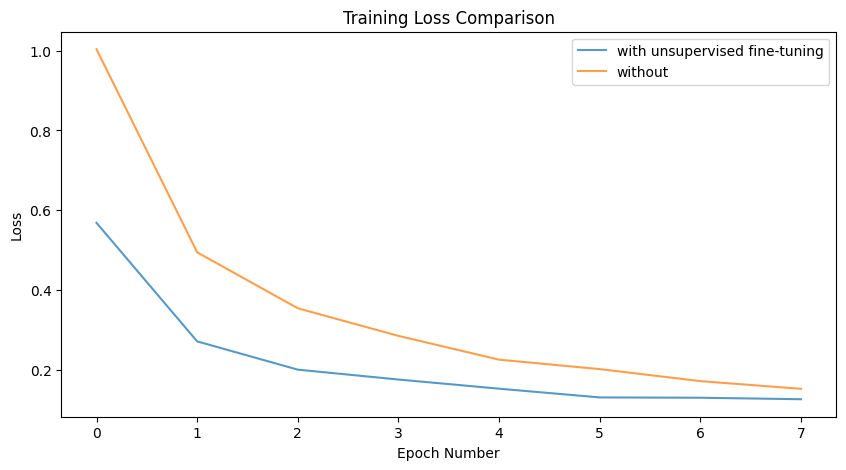

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(mlm_train_losses, label="with unsupervised fine-tuning", alpha=0.75)
plt.plot(train_losses, label="without", alpha=0.75)
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

- And on the test data:

In [25]:
metrics_df = pd.DataFrame({
    'without': metrics,
    'with': metrics_mlm
})

print(metrics_df)

      without      with
MSE  0.472255  0.425943
MAE  0.531588  0.494172
R2   0.680363  0.711709
